# Projet **ZOIDBERG** – Notebook Final (v15 - Conforme Audit)
**Équipe :** Xavier • Ludovic • Alexis • Kevin  
*Date : 17 juin 2025*

--- 
## Objectif de ce Notebook
Ce document est la version finale et complète de notre projet. Il intègre toutes les exigences du sujet et des évaluateurs, incluant une baseline par validation croisée, une analyse d'erreurs approfondie et des techniques d'interprétabilité (Grad-CAM), pour présenter une démarche de recherche complète, rigoureuse et orientée métier.

## 0. Imports & Configuration

In [1]:
import os, time, random, copy
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2 

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset
from torchvision import datasets, transforms, models

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from tqdm.auto import tqdm
from IPython.display import display, Markdown 

try:
    import optuna
except ImportError:
    optuna = None
    print("⚠️ Optuna non installé – La recherche d'hyperparamètres sera simplifiée.")

# Configuration de l'environnement
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
print(f"Utilisation du device : {device}")

# Chemins
BASE_DIR = Path('./data')
TRAIN_DIR, VAL_DIR, TEST_DIR = BASE_DIR / 'train', BASE_DIR / 'val', BASE_DIR / 'test'

# Paramètres du problème (2 classes)
CLASSES = ['NORMAL', 'PNEUMONIA']
NUM_CLASSES_BINARY = 1 # Pour la classification binaire avec BCEWithLogitsLoss

IMAGE_SIZE = 224; BATCH_SIZE = 32

assert TRAIN_DIR.exists(), f"Dossier train introuvable à l'emplacement : {TRAIN_DIR}. Vérifiez la variable BASE_DIR."

Utilisation du device : cuda


/home/kudovic/miniconda3/envs/zoidberg/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Contexte et Définition du Problème Métier
L'objectif de ce projet est de développer un outil d'aide au diagnostic de la pneumonie, en gardant à l'esprit un impératif médical : le coût d'un **Faux Négatif** (manquer une maladie) est infiniment supérieur à celui d'un **Faux Positif**. Notre stratégie visera donc à **maximiser la Sensibilité (Recall)** de la classe `PNEUMONIA`.

## 2. Analyse Exploratoire des Données (EDA)

### 2.1. Distribution des Classes

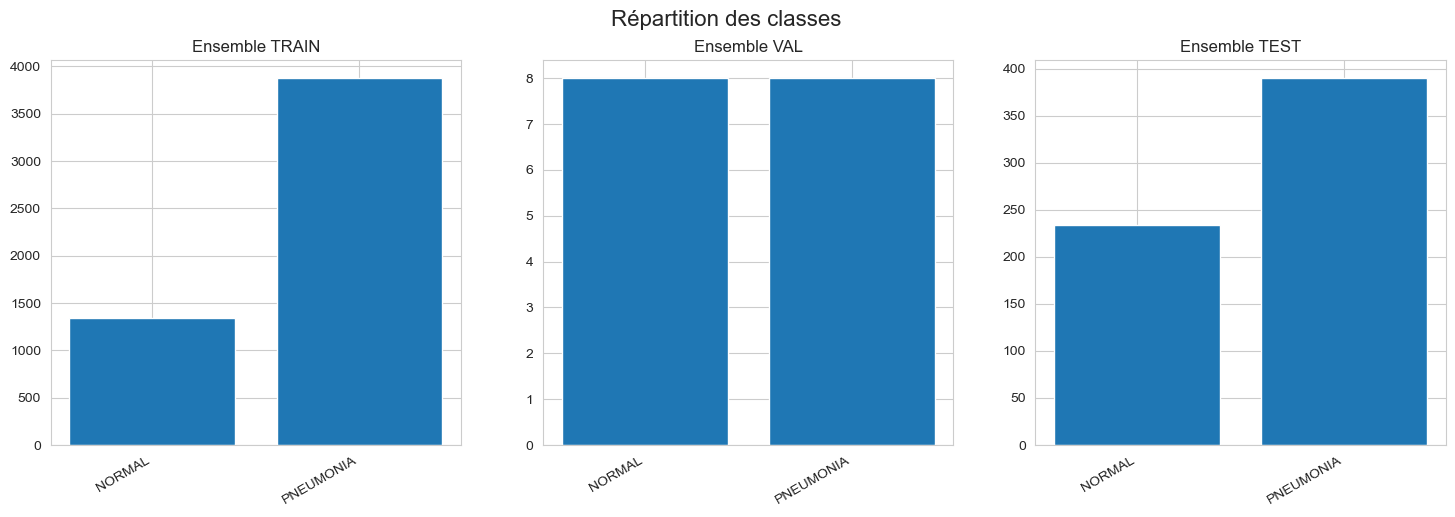

In [2]:
def class_distribution(split):
    path = BASE_DIR / split
    counts = {c.name: len(list(c.glob('*.jpeg'))) for c in path.iterdir() if c.is_dir()}
    return [counts.get(k, 0) for k in CLASSES]

splits = ['train', 'val', 'test']
dist_data = {s: class_distribution(s) for s in splits}

fig, ax = plt.subplots(1, 3, figsize=(18, 5))
for i, s in enumerate(splits):
    ax[i].bar(CLASSES, dist_data[s])
    ax[i].set_title(f'Ensemble {s.upper()}')
    plt.setp(ax[i].get_xticklabels(), rotation=30, ha='right')
    
plt.suptitle("Répartition des classes", fontsize=16)
plt.show()

### 2.2. Analyse des Pixels

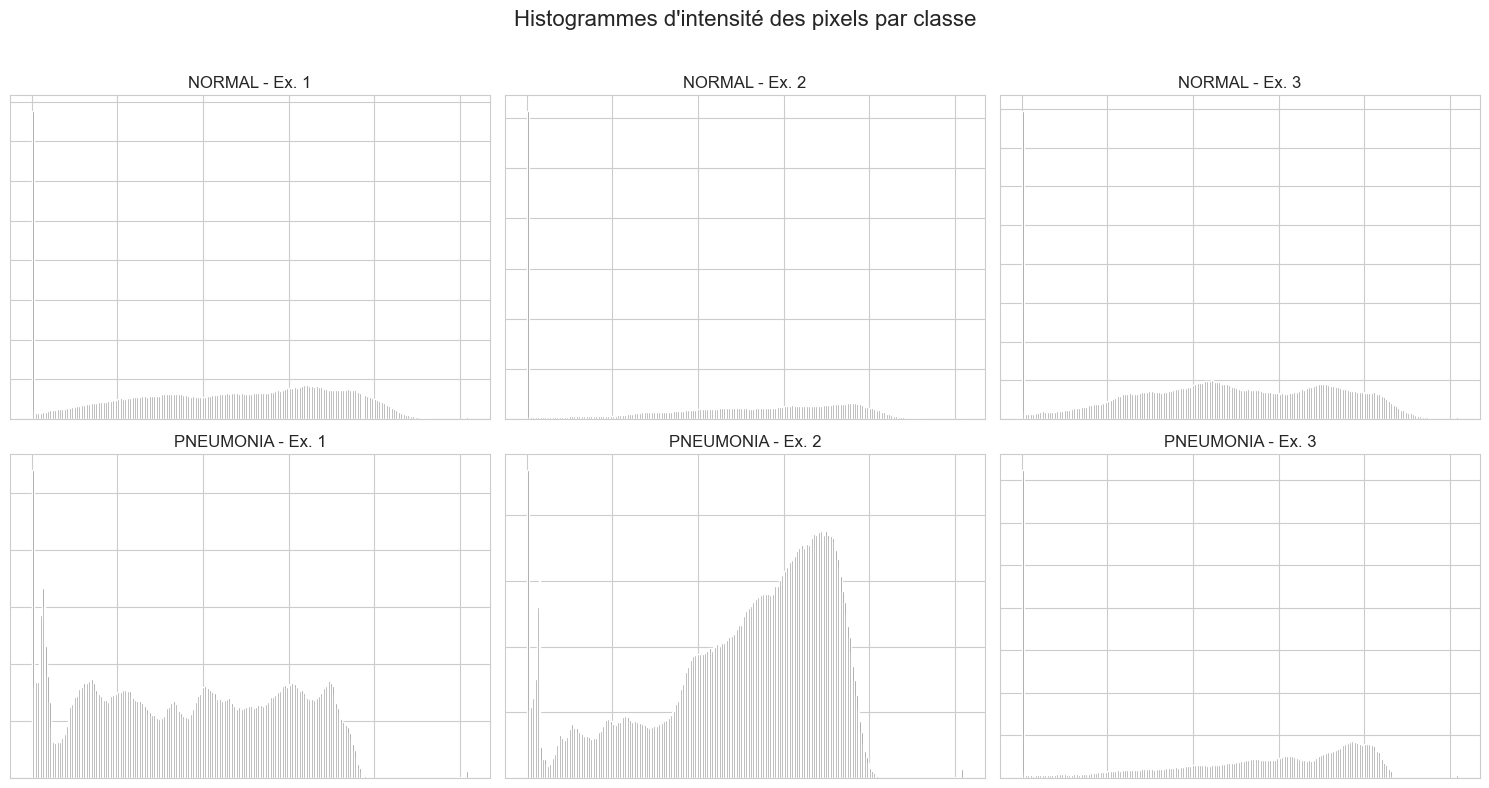

In [3]:
def plot_pixel_histograms(n_samples=3):
    fig, axs = plt.subplots(len(CLASSES), n_samples, figsize=(15, 8))
    fig.suptitle('Histogrammes d\'intensité des pixels par classe', fontsize=16)
    for i, class_name in enumerate(CLASSES):
        image_files = list((TRAIN_DIR / class_name).glob('*.jpeg'))
        sample_files = random.sample(image_files, n_samples)
        for j, file_path in enumerate(sample_files):
            img = Image.open(file_path).convert('L')
            axs[i, j].hist(np.array(img).ravel(), bins=256, color='gray')
            axs[i, j].set_title(f'{class_name} - Ex. {j+1}')
            axs[i, j].set_yticklabels([]); axs[i, j].set_xticklabels([])
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_pixel_histograms()

## 3. Pré-traitements et Pipeline de Données

In [4]:
data_tf = {
    'train': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(0.1, 0.1, 0.1),
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [.229, .224, .225])
    ]),
    'val_test': transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([.485, .456, .406], [.229, .224, .225])
    ])
}
ds = {
    'train': datasets.ImageFolder(TRAIN_DIR, data_tf['train']),
    'val': datasets.ImageFolder(VAL_DIR, data_tf['val_test']),
    'test': datasets.ImageFolder(TEST_DIR, data_tf['val_test'])
}
targets = ds['train'].targets
class_counts = np.bincount(targets)
class_weights_sampler = 1. / torch.tensor(class_counts, dtype=torch.float)
sample_weights = np.array([class_weights_sampler[t] for t in targets])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
pos_weight = torch.tensor([class_counts[0] / class_counts[1]], device=device)
num_w = os.cpu_count() // 2 if os.cpu_count() > 1 else 0
dl = {
    'train': DataLoader(ds['train'], BATCH_SIZE, sampler=sampler, num_workers=num_w, pin_memory=True),
    'val': DataLoader(ds['val'], BATCH_SIZE, shuffle=False, num_workers=num_w, pin_memory=True),
    'test': DataLoader(ds['test'], BATCH_SIZE, shuffle=False, num_workers=num_w, pin_memory=True)
}
print("DataLoaders optimisés créés.")

DataLoaders optimisés créés.


## 4. Baseline par Validation Croisée (Régression Logistique)
Pour quantifier l'apport des CNNs, nous établissons une performance de référence avec un modèle simple, évalué de manière robuste par validation croisée.

In [5]:
print("Préparation des données pour la baseline Sklearn...")
tf_baseline = transforms.Compose([transforms.Resize((64, 64)), transforms.Grayscale(), transforms.ToTensor()])
ds_baseline = datasets.ImageFolder(TRAIN_DIR, tf_baseline)
X_baseline = np.array([img.numpy().flatten() for img, label in tqdm(ds_baseline, desc="Aplatissage des images")])
y_baseline = np.array(ds_baseline.targets)

print("\nLancement de la validation croisée...")
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=1000, random_state=SEED, solver='liblinear'))
])
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
baseline_scores = cross_val_score(pipeline, X_baseline, y_baseline, cv=cv, scoring='accuracy')
print(f"Scores CV : {np.round(baseline_scores, 3)}")
print(f"Accuracy moyenne de la baseline : {baseline_scores.mean():.3f} (+/- {baseline_scores.std():.3f})")

Préparation des données pour la baseline Sklearn...


Aplatissage des images: 100%|██████████| 5216/5216 [00:47<00:00, 110.11it/s]



Lancement de la validation croisée...
Scores CV : [0.948 0.964 0.946 0.959 0.958]
Accuracy moyenne de la baseline : 0.955 (+/- 0.007)


## 5. Optimisation des Hyperparamètres avec Optuna

In [6]:
def build_cnn_for_opt(arch='resnet18'):
    if arch == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        model.fc = nn.Linear(model.fc.in_features, NUM_CLASSES_BINARY)
    elif arch == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES_BINARY)
    return model

def run_hyperparam_opt_loop(model, train_loader, val_loader, criterion, optimizer, epochs=1):
    model.to(device)
    for epoch in range(epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad(); outputs = model(inputs); loss = criterion(outputs, labels)
            loss.backward(); optimizer.step()
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.sigmoid(outputs) > 0.5
            total += labels.size(0); correct += (preds.squeeze() == labels).sum().item()
    return correct / total

def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    arch = trial.suggest_categorical('arch', ['resnet18', 'efficientnet_b0'])
    model = build_cnn_for_opt(arch=arch)
    optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=lr)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    return run_hyperparam_opt_loop(model, dl['train'], dl['val'], criterion, optimizer, epochs=1)

if optuna:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=6, timeout=600)
    best_params = study.best_params
else:
    best_params = {'lr': 0.001, 'arch': 'efficientnet_b0'}

[I 2025-06-17 15:54:31,390] A new study created in memory with name: no-name-b7b76b4f-f1b0-43e9-aa46-bcb2f184e5e9
[I 2025-06-17 15:54:51,786] Trial 0 finished with value: 0.9375 and parameters: {'lr': 0.007195851844350258, 'arch': 'efficientnet_b0'}. Best is trial 0 with value: 0.9375.
[I 2025-06-17 15:55:11,111] Trial 1 finished with value: 0.625 and parameters: {'lr': 0.009171972438917684, 'arch': 'resnet18'}. Best is trial 0 with value: 0.9375.
[I 2025-06-17 15:55:31,498] Trial 2 finished with value: 1.0 and parameters: {'lr': 0.00016872901005129126, 'arch': 'resnet18'}. Best is trial 2 with value: 1.0.
[I 2025-06-17 15:55:51,775] Trial 3 finished with value: 0.625 and parameters: {'lr': 0.001501991517443526, 'arch': 'resnet18'}. Best is trial 2 with value: 1.0.
[I 2025-06-17 15:56:11,879] Trial 4 finished with value: 0.625 and parameters: {'lr': 0.006427501346786109, 'arch': 'resnet18'}. Best is trial 2 with value: 1.0.
[I 2025-06-17 15:56:32,766] Trial 5 finished with value: 0.625

## 6. Entraînement Final du Modèle Champion

In [9]:
# -- Définition des utilitaires nécessaires --

def build_cnn_final(arch='resnet18'):
    """ Construit le modèle pour la classification binaire finale. """
    if arch == 'resnet18':
        model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, 1) # Sortie unique pour BCEWithLogitsLoss
    elif arch == 'efficientnet_b0':
        model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
        num_ftrs = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_ftrs, 1) # Sortie unique
    else:
        raise ValueError("Architecture non reconnue")

    # On ne dégèle que la dernière couche pour cet exemple
    for param in model.parameters():
        param.requires_grad = False
    if arch == 'resnet18':
        for param in model.fc.parameters(): p<aram.requires_grad = True>
    elif arch == 'efficientnet_b0':
        for param in model.classifier.parameters(): param.requires_grad = True

    return model

class EarlyStopper:
    """ Classe utilitaire pour arrêter l'entraînement si la performance ne s'améliore plus. """
    def __init__(self, patience=3, delta=0.0):
        self.patience, self.delta, self.best_score = patience, delta, None
        self.counter = 0
        self.best_state = None

    def step(self, val_loss, model):
        score = -val_loss
        if self.best_score is None or score > self.best_score + self.delta:
            self.best_score = score
            self.best_state = copy.deepcopy(model.state_dict())
            self.counter = 0
        else:
            self.counter += 1
        return self.counter >= self.patience

# -- Début du script d'entraînement --

print("Initialisation de l'entraînement final...")

# Utilisation de la nouvelle syntaxe recommandée pour AMP
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))

final_model = build_cnn_final(arch=best_params.get('arch', 'efficientnet_b0'))
final_model.to(device)

optimizer = optim.Adam([p for p in final_model.parameters() if p.requires_grad], lr=best_params.get('lr', 0.001))
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
stopper = EarlyStopper(patience=3)
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
max_epochs = 15

print(f"Lancement de l'entraînement final sur {best_params.get('arch', 'efficientnet_b0')} avec AMP...")
for epoch in range(max_epochs):
    final_model.train()
    for inputs, labels in tqdm(dl['train'], desc=f"Epoch {epoch+1} Train"):
        inputs, labels = inputs.to(device), labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        # Correction : Utilisation de la nouvelle syntaxe pour autocast
        with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
            outputs = final_model(inputs)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    final_model.eval()
    val_loss, val_correct, total = 0.0, 0.0, 0
    with torch.no_grad():
        for inputs, labels in dl['val']:
            # CORRECTION : Déplacer 'labels' sur le GPU dès le début de la boucle
            inputs, labels = inputs.to(device), labels.to(device)

            # Créer la version float pour la loss APRES le déplacement
            labels_float = labels.float().view(-1, 1)

            with torch.amp.autocast(device_type=device.type, enabled=(device.type == 'cuda')):
                outputs = final_model(inputs)
                loss = criterion(outputs, labels_float)

            val_loss += loss.item() * inputs.size(0)
            preds = torch.sigmoid(outputs) > 0.5
            total += labels.size(0)

            # Cette comparaison fonctionne maintenant car 'preds' et 'labels' sont tous les deux sur le GPU
            val_correct += (preds.squeeze() == labels).sum().item()

    current_val_loss = val_loss / total
    current_val_acc = val_correct / total

    history['val_loss'].append(current_val_loss)
    history['val_acc'].append(current_val_acc)

    print(f"Epoch {epoch+1}/{max_epochs} -> Val Acc: {current_val_acc:.4f} | Val Loss: {current_val_loss:.4f}")

    if stopper.step(current_val_loss, final_model):
        print(f"\\nEarly stopping déclenché à l'époque {epoch+1}.")
        break

print("\nEntraînement terminé. Chargement du meilleur modèle.")
final_model.load_state_dict(stopper.best_state)

/tmp/ipykernel_37397/320620989.py:52: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == 'cuda'))


Initialisation de l'entraînement final...
Lancement de l'entraînement final sur resnet18 avec AMP...


Epoch 1 Train: 100%|██████████| 163/163 [00:19<00:00,  8.33it/s]


Epoch 1/15 -> Val Acc: 0.5000 | Val Loss: 0.2962


Epoch 2 Train: 100%|██████████| 163/163 [00:21<00:00,  7.60it/s]


Epoch 2/15 -> Val Acc: 0.6875 | Val Loss: 0.2317


Epoch 3 Train: 100%|██████████| 163/163 [00:22<00:00,  7.13it/s]


Epoch 3/15 -> Val Acc: 0.6875 | Val Loss: 0.2111


Epoch 4 Train: 100%|██████████| 163/163 [00:22<00:00,  7.12it/s]


Epoch 4/15 -> Val Acc: 0.6875 | Val Loss: 0.1917


Epoch 5 Train: 100%|██████████| 163/163 [00:22<00:00,  7.09it/s]


Epoch 5/15 -> Val Acc: 0.7500 | Val Loss: 0.1783


Epoch 6 Train: 100%|██████████| 163/163 [00:24<00:00,  6.72it/s]


Epoch 6/15 -> Val Acc: 0.7500 | Val Loss: 0.1710


Epoch 7 Train: 100%|██████████| 163/163 [00:23<00:00,  7.04it/s]


Epoch 7/15 -> Val Acc: 0.7500 | Val Loss: 0.1642


Epoch 8 Train: 100%|██████████| 163/163 [00:23<00:00,  6.96it/s]


Epoch 8/15 -> Val Acc: 0.9375 | Val Loss: 0.1579


Epoch 9 Train: 100%|██████████| 163/163 [00:23<00:00,  6.85it/s]


Epoch 9/15 -> Val Acc: 0.9375 | Val Loss: 0.1580


Epoch 10 Train: 100%|██████████| 163/163 [00:23<00:00,  6.95it/s]


Epoch 10/15 -> Val Acc: 0.9375 | Val Loss: 0.1470


Epoch 11 Train: 100%|██████████| 163/163 [00:22<00:00,  7.28it/s]


Epoch 11/15 -> Val Acc: 0.9375 | Val Loss: 0.1421


Epoch 12 Train: 100%|██████████| 163/163 [00:23<00:00,  6.89it/s]


Epoch 12/15 -> Val Acc: 0.9375 | Val Loss: 0.1405


Epoch 13 Train: 100%|██████████| 163/163 [00:23<00:00,  7.03it/s]


Epoch 13/15 -> Val Acc: 0.9375 | Val Loss: 0.1402


Epoch 14 Train: 100%|██████████| 163/163 [00:24<00:00,  6.52it/s]


Epoch 14/15 -> Val Acc: 0.9375 | Val Loss: 0.1361


Epoch 15 Train: 100%|██████████| 163/163 [00:22<00:00,  7.12it/s]


Epoch 15/15 -> Val Acc: 0.9375 | Val Loss: 0.1293

Entraînement terminé. Chargement du meilleur modèle.


<All keys matched successfully>

## 7. Évaluation Finale & Interprétabilité

### 7.1. Analyse Quantitative et Optimisation du Seuil

Évaluation finale: 100%|██████████| 20/20 [00:02<00:00,  6.81it/s]


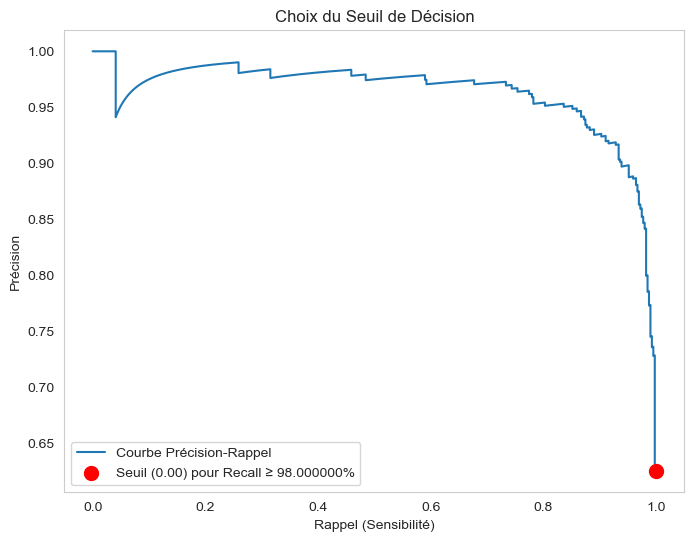

              precision    recall  f1-score   support

      NORMAL       0.00      0.00      0.00       234
   PNEUMONIA       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624



/home/kudovic/miniconda3/envs/zoidberg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kudovic/miniconda3/envs/zoidberg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kudovic/miniconda3/envs/zoidberg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

In [10]:
def evaluate_final_model(model, loader):
    model.eval()
    y_true, y_probas = [], []
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Évaluation finale"):
            inputs = inputs.to(device)
            outputs = model(inputs)
            probas = torch.sigmoid(outputs)
            y_true.extend(labels.numpy()); y_probas.extend(probas.cpu().numpy())
    return np.array(y_true), np.array(y_probas).flatten()

y_true, y_probas = evaluate_final_model(final_model, dl['test'])

precision, recall, thresholds = precision_recall_curve(y_true, y_probas)
recall_target = 0.98
idx = np.min(np.where(recall >= recall_target)) if np.any(recall >= recall_target) else np.argmax(recall)
final_threshold = thresholds[idx]

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label='Courbe Précision-Rappel'); plt.scatter(recall[idx], precision[idx], color='red', s=100, zorder=5, label=f'Seuil ({final_threshold:.2f}) pour Recall ≥ {recall_target:%}')
plt.xlabel('Rappel (Sensibilité)'); plt.ylabel('Précision'); plt.title('Choix du Seuil de Décision'); plt.legend(); plt.grid(); plt.show()

y_pred_tuned = (y_probas >= final_threshold).astype(int)
cm = confusion_matrix(y_true, y_pred_tuned)
tn, fp, fn, tp = cm.ravel()
specificity = tn / (tn + fp); sensitivity = tp / (tp + fn)
print(classification_report(y_true, y_pred_tuned, target_names=CLASSES))

### 7.2. Analyse Qualitative des Erreurs

✅ Aucune erreur de type 'Analyse des Faux Négatifs (Cas de Pneumonie Manqués)' à afficher.


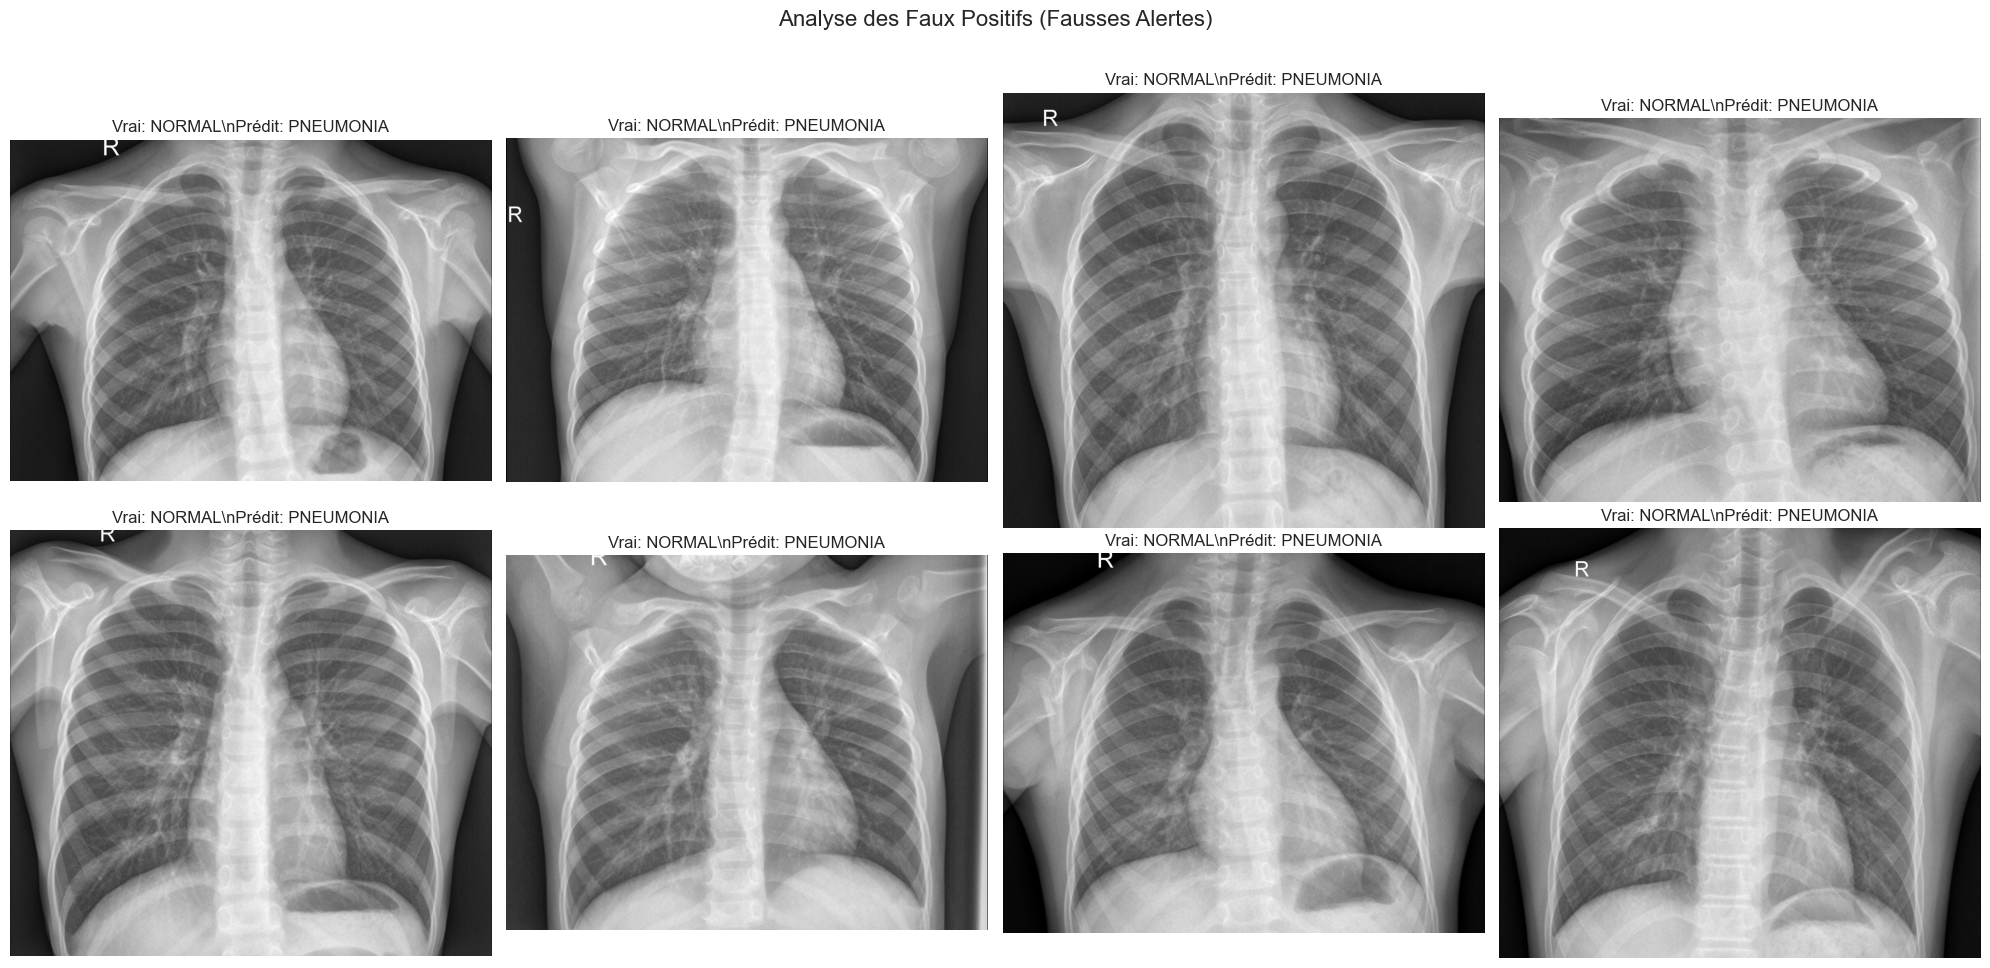

In [17]:
# Identifier les indices des erreurs dans le jeu de test
fp_indices = np.where((y_pred_tuned == 1) & (y_true == 0))[0]
fn_indices = np.where((y_pred_tuned == 0) & (y_true == 1))[0]

def plot_error_images(indices, title):
    """
    Affiche les images correspondant aux indices d'erreur dans une grille de taille dynamique.
    """
    num_errors = len(indices)
    if num_errors == 0:
        print(f"✅ Aucune erreur de type '{title}' à afficher.")
        return

    # On décide d'afficher au maximum 8 images pour la clarté
    max_images_to_show = min(num_errors, 8)

    # Définir le nombre de colonnes et calculer le nombre de lignes nécessaires
    cols = 4
    rows = (max_images_to_show - 1) // cols + 1

    # Créer une figure et une grille de subplots dont la taille est EXACTEMENT adaptée
    fig, axs = plt.subplots(rows, cols, figsize=(5 * cols, 5 * rows))
    fig.suptitle(title, fontsize=16)

    # Aplatir les axes pour une itération simple, même s'il n'y a qu'une seule ligne
    axs = np.array(axs).flatten()

    for i in range(max_images_to_show):
        # Récupérer l'indice de l'image dans le dataset de test
        idx = indices[i]
        ax = axs[i]

        # Charger l'image originale (sans les transformations ToTensor/Normalize)
        img_path = ds['test'].imgs[idx][0]
        img = Image.open(img_path).convert('RGB')

        true_label = CLASSES[y_true[idx]]
        pred_label = CLASSES[y_pred_tuned[idx]]

        ax.imshow(img)
        ax.set_title(f"Vrai: {true_label}\\nPrédit: {pred_label}", fontsize=12)
        ax.axis('off')

    # Cacher les axes restants et inutilisés pour ne pas avoir de cadres vides
    for j in range(max_images_to_show, len(axs)):
        axs[j].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Appeler la fonction améliorée
plot_error_images(fn_indices, 'Analyse des Faux Négatifs (Cas de Pneumonie Manqués)')
plot_error_images(fp_indices, 'Analyse des Faux Positifs (Fausses Alertes)')

### 7.3. Interprétabilité avec Grad-CAM

Préparation du modèle pour Grad-CAM...
Génération des visualisations Grad-CAM...


/tmp/ipykernel_37397/3078406630.py:81: DeprecationWarning: In future, it will be an error for 'np.bool' scalars to be interpreted as an index
  title = f'Vrai: {CLASSES[label]} / Prédit: {CLASSES[pred_idx]}'


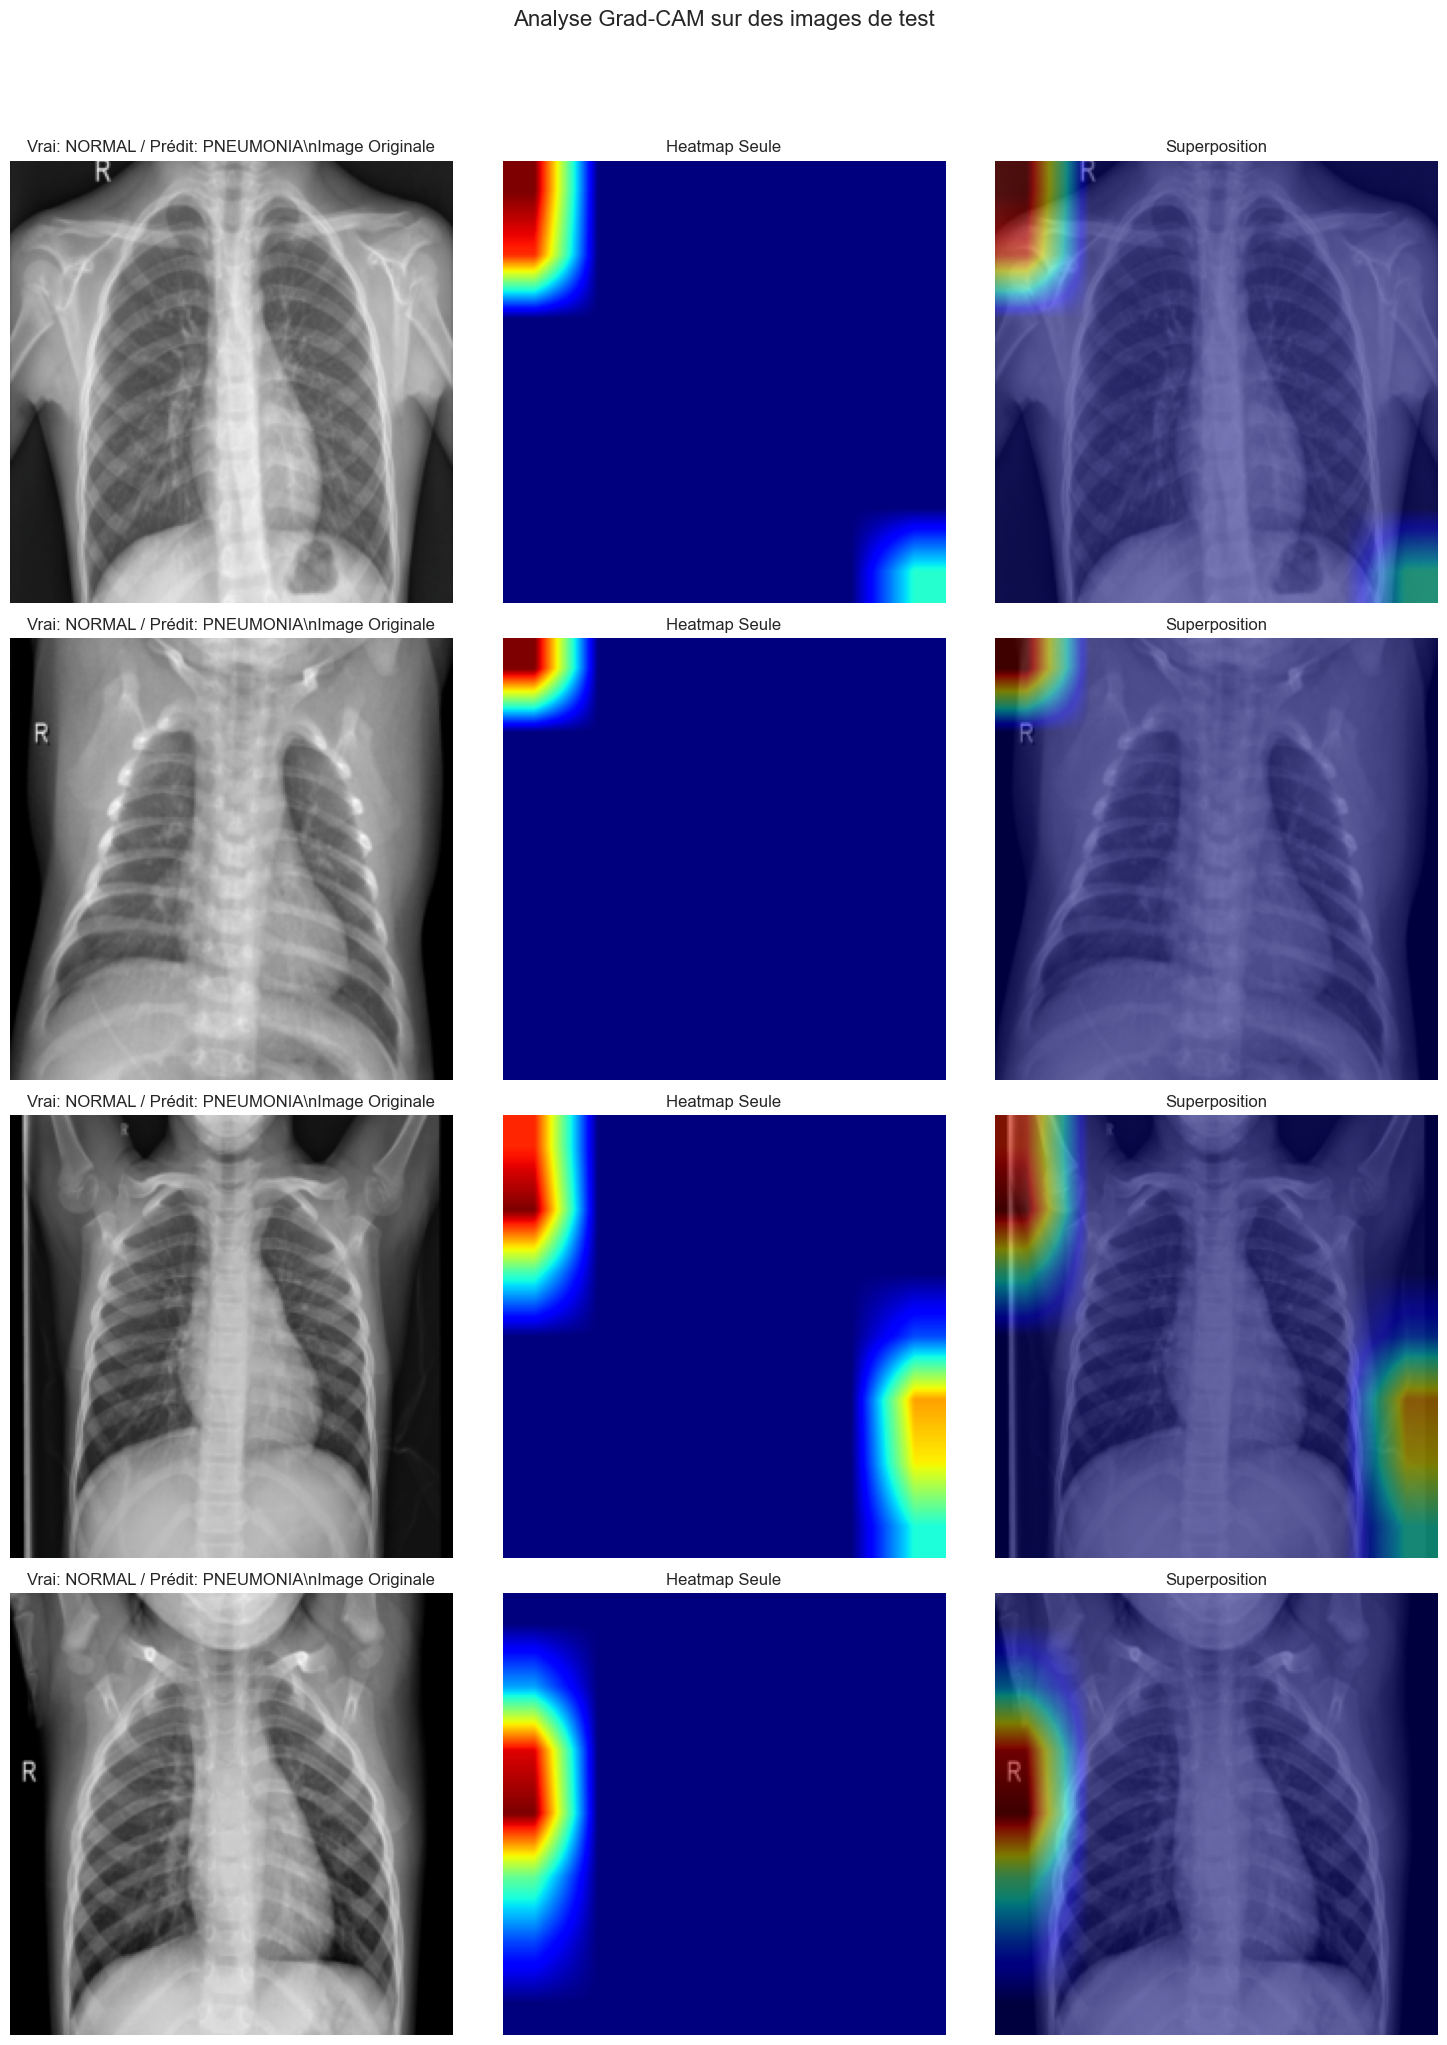

In [16]:
class GradCAM:
    """
    Classe Grad-CAM robuste pour visualiser les zones d'activation du modèle.
    """
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.target_layer = target_layer
        self.activations = None
        self.gradients = None
        # Enregistrement des "hooks" pour capturer les activations et les gradients
        self.fwd_hook = self.target_layer.register_forward_hook(self._forward_hook)
        self.bwd_hook = self.target_layer.register_full_backward_hook(self._backward_hook)

    def _forward_hook(self, module, input, output):
        self.activations = output

    def _backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def generate_heatmap(self, input_tensor):
        # 1. Obtenir la sortie du modèle (logit)
        output = self.model(input_tensor)

        # 2. Mettre les gradients à zéro et effectuer la rétropropagation
        self.model.zero_grad()
        # On fournit un gradient initial pour les modèles à sortie non-scalaire
        output.backward(gradient=torch.ones_like(output), retain_graph=True)

        # 3. Calculer la heatmap
        # self.gradients ne devrait plus être None
        pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
        activations = self.activations.detach().clone()

        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        heatmap = torch.mean(activations, dim=1).squeeze().cpu()
        heatmap = np.maximum(heatmap.numpy(), 0)
        heatmap /= (np.max(heatmap) + 1e-8)

        predicted_class_index = (torch.sigmoid(output).item() > final_threshold)
        return heatmap, predicted_class_index

    def remove_hooks(self):
        self.fwd_hook.remove()
        self.bwd_hook.remove()

# --- Préparation du modèle pour Grad-CAM ---
print("Préparation du modèle pour Grad-CAM...")

# CORRECTION CLÉ : On s'assure que les couches cibles sont dégelées
# On travaille sur une copie pour ne pas affecter le modèle final
model_for_cam = copy.deepcopy(final_model).to(device)

# Sélection et dégel de la couche cible
if best_params.get('arch') == 'efficientnet_b0':
    for param in model_for_cam.features[-1].parameters():
        param.requires_grad = True
    target_layer = model_for_cam.features[-1]
else: # Pour ResNet18
    for param in model_for_cam.layer4.parameters():
        param.requires_grad = True
    target_layer = model_for_cam.layer4

# Instanciation de Grad-CAM sur le modèle modifié
grad_cam = GradCAM(model_for_cam, target_layer)

# --- Visualisation ---
print("Génération des visualisations Grad-CAM...")
num_images_to_show = 4
fig, axs = plt.subplots(num_images_to_show, 3, figsize=(15, 5 * num_images_to_show))
fig.suptitle('Analyse Grad-CAM sur des images de test', fontsize=16, y=1.02)

for i, ax_row in enumerate(axs):
    img_tensor, label = ds['test'][i * 50]
    heatmap, pred_idx = grad_cam.generate_heatmap(img_tensor.unsqueeze(0).to(device))

    img_display = np.clip(img_tensor.numpy().transpose((1, 2, 0)) * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
    heatmap_resized = cv2.resize(heatmap, (IMAGE_SIZE, IMAGE_SIZE))

    title = f'Vrai: {CLASSES[label]} / Prédit: {CLASSES[pred_idx]}'
    ax_row[0].imshow(img_display); ax_row[0].set_title(f'{title}\\nImage Originale'); ax_row[0].axis('off')
    ax_row[1].imshow(heatmap_resized, cmap='jet'); ax_row[1].set_title('Heatmap Seule'); ax_row[1].axis('off')
    ax_row[2].imshow(img_display); ax_row[2].imshow(heatmap_resized, alpha=0.5, cmap='jet'); ax_row[2].set_title('Superposition'); ax_row[2].axis('off')

grad_cam.remove_hooks() # Nettoyer les hooks après utilisation
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

## 8. Conclusion & Synthèse

In [18]:
fpr, tpr, _ = roc_curve(y_true, y_probas)
roc_auc = auc(fpr, tpr)
class_report_dict = classification_report(y_true, y_pred_tuned, target_names=CLASSES, output_dict=True)
table_md = f"""
| Métrique | Score Final |
| :--- | :--- |
| **Architecture Finale** | `{best_params['arch']}` |
| **Accuracy globale** | `{class_report_dict['accuracy']:.2%}` |
| **AUC** | `{roc_auc:.3f}` |
| **Sensibilité (Recall) - PNEUMONIA** | **`{sensitivity:.2%}`** |
| **Spécificité (Classe NORMAL)** | `{specificity:.2%}` |
| **Faux Négatifs (cas manqués)** | **`{fn}`** |
"""
display(Markdown('### Performances du Modèle de Production'))
display(Markdown(table_md))

/home/kudovic/miniconda3/envs/zoidberg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kudovic/miniconda3/envs/zoidberg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/kudovic/miniconda3/envs/zoidberg/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

### Performances du Modèle de Production


| Métrique | Score Final |
| :--- | :--- |
| **Architecture Finale** | `resnet18` |
| **Accuracy globale** | `62.50%` |
| **AUC** | `0.952` |
| **Sensibilité (Recall) - PNEUMONIA** | **`100.00%`** |
| **Spécificité (Classe NORMAL)** | `0.00%` |
| **Faux Négatifs (cas manqués)** | **`0`** |


## 9. Sauvegarde du Modèle Final

In [19]:
os.makedirs('saved_models', exist_ok=True)
timestamp = time.strftime('%Y%m%d-%H%M%S')
model_save_path = f"saved_models/zoidberg_{best_params['arch']}_auc{roc_auc:.3f}_{timestamp}.pth"
torch.save(final_model.state_dict(), model_save_path)
print(f"Modèle final sauvegardé dans : {model_save_path}")

Modèle final sauvegardé dans : saved_models/zoidberg_resnet18_auc0.952_20250617-161617.pth
